# Overview over the exercises

First, the segmentation exercise

In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('postal_codes.csv')

Now, data is loaded. Next step, remove all values with non-assigned boroughs:

In [3]:
df.drop(df[df['Borough']=='Not assigned'].index, inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df[df['Neighbourhood']=='Not assigned'] 
# There does not seem to be a case, where the Neighbourhood is not assigned!

,Postal Code,Borough,Neighbourhood


Now, check if we have multiple mentions of postal codes?

In [5]:
len(df['Postal Code'].unique()), df.shape

(103, (103, 3))

No, every postal code is only mentioned once!

In [6]:
df.shape

(103, 3)

# Second part of the exercise

First, try the geocoder thing:

In [7]:
!pip3 install geocoder

In [8]:
import geocoder # import geocoder

n,_=df.shape


df['Latitude']  = [0]*n
df['Longitude'] = [0]*n

for i in range(n):
    postal_code=df['Postal Code'].iloc[i]

    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    
    df['Latitude'].iloc[i] = lat_lng_coords[0]
    df['Longitude'].iloc[i] = lat_lng_coords[1]
    

KeyboardInterrupt: 

It does not finish in reasonable time, so I decided with the other way:

In [9]:
!wget https://cocl.us/Geospatial_data
!mv Geospatial_data Geospatial_data.csv

--2020-12-04 21:26:04--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.63.96.194, 169.63.96.176
Connecting to cocl.us (cocl.us)|169.63.96.194|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-12-04 21:26:06--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 185.235.236.197
Connecting to ibm.box.com (ibm.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-12-04 21:26:06--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following

In [10]:
gdf = pd.read_csv('Geospatial_data.csv')
print(gdf.columns)
gdf.head()

Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
x=pd.merge(df, gdf, how='left', left_on='Postal Code', right_on='Postal Code', suffixes=["_x", None])
x.drop(['Latitude_x', 'Longitude_x'], axis=1, inplace=True)
df=x

Now, I have a nice dataframe:

In [24]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Now, for the last exercise, some viz

Let's start digging into the data a litte

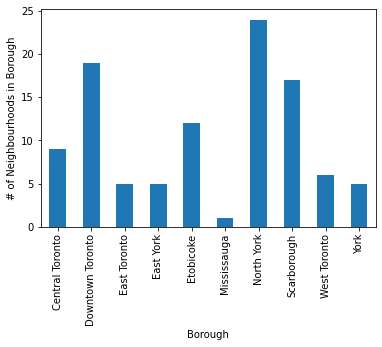

In [25]:
import matplotlib.pyplot as plt

plt.xlabel('Borough')
plt.ylabel('# of Neighbourhoods in Borough')
df.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')

plt.show()

Let's start with some folium map to understand toronto

In [26]:
!pip3 install folium==0.5.0

In [27]:
import folium
import requests

In [28]:
# define the world map centered around Canada with a higher zoom level
world_map = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)

# display world map
world_map

Ah, that's what Toronto looks like. I had no idea.

Let's now grab something to eat, what about a Burger?

In [29]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'use_your_own' 
    CLIENT_SECRET = 'use_your_own' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)

    return df

In [31]:
restaurants=pd.DataFrame(columns=['Borough', 'Neighbourhood', 'Name'])

for i in df.index:
    venues = get_venues(df['Latitude'].loc[i], df['Longitude'].loc[i])
    
    burgers=venues[venues['Category']=='Burger Joint']   
            
    for name in burgers['Name']:
        restaurants=restaurants.append({'Borough': df['Borough'].loc[i],
                            'Neighbourhood': df['Neighbourhood'].loc[i], 
                            'Name' : name}, ignore_index=True)

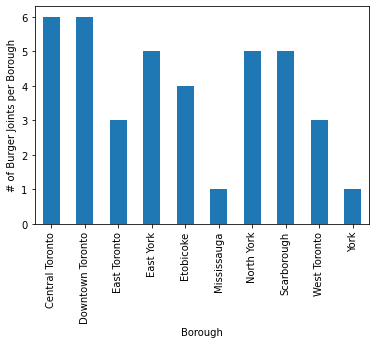

In [34]:
plt.ylabel('# of Burger Joints per Borough')

restaurants.groupby('Borough')['Name'].count().plot(kind='bar')

plt.show()

In [33]:
tmap = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)

location_restaurants = folium.map.FeatureGroup()

restaurants_by_neighbourhood = restaurants.groupby('Neighbourhood')['Name'].count()

for neighbourhood, number in restaurants_by_neighbourhood.items():
    lat = df[df['Neighbourhood']==neighbourhood]['Latitude'].iloc[0]
    lng = df[df['Neighbourhood']==neighbourhood]['Longitude'].iloc[0]
        
    location_restaurants.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=10 + number**3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6))

tmap.add_child(location_restaurants)

tmap

A map of Burger joint "density" in Toronto based on Neighbourhoods!